In [1]:
import pandas as pd
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from glob import glob
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, GlobalAveragePooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization
import cv2
import pickle
from scipy.ndimage import median_filter, convolve
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import classification_report,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras import applications

sys.version

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'3.6.9 (default, Jul 17 2020, 12:50:27) \n[GCC 8.4.0]'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/My Drive/flowers"

categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
# przygotowanie i zaczytanie danych
data = []
def make_data():
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)
        
        for img_name in os.listdir(path):
            image_path = os.path.join(path, img_name)
            image = cv2.imread(image_path)
            
            try:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (224,224))
                
                image = np.array(image, dtype=np.float32)
                
                data.append([image, label])
            except Exception as e:
                pass
    print(len(data))
    
    pik = open('data.pickle', 'wb')
    pickle.dump(data,pik)
    pik.close()

In [ ]:
make_data()

4323


In [ ]:
def load_data():
    pick = open('data.pickle','rb')
    data = pickle.load(pick)
    pick.close()
    
    np.random.shuffle(data)
    
    feature = []
    labels = []
    
    for img, label in data:
        feature.append(img)
        labels.append(label)
        
    feature = np.array(feature, dtype=np.float32)
    labels = np.array(labels)
    
    feature = feature/255.0
    
    return [feature, labels]

In [ ]:
(feature, labels) = load_data()

In [ ]:
#preprocessing labelek 
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split (feature, labels, test_size = 0.2, random_state = 0)

In [ ]:
# dodatkowy podział danych testowych
X_test,X_valid, y_test, y_valid = train_test_split(x_test,y_test, test_size = 0.5)

In [ ]:
#MODEL VGG16 z wagami imagenet jako model bazowy
#załadowanie modelu VGG16 bez ostatniej warstwy
base_model = applications.VGG16(weights='imagenet', include_top=False)
print('wczytano model!')

# zamrożenie pierwszych warstw (nie będą trenowane)
for layer in base_model.layers[:15]:
    layer.trainable = False
    
base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Loaded model!
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
________________________________________________

In [ ]:
# top_model dodawany do modelu bazowego 
top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(5, activation='softmax')) 
top_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 2,565
Trainable params: 2,565
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Połączenie modeli base i top
model = Sequential()
model.add(base_model)
model.add(top_model)
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
sequential (Sequential)      (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 7,081,989
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
# Trenowanie modelu z użyciem generatorów na 100 epokach
epochs = 100
batch_size=32
best_model_finetuned_path = 'best_finetuned_model.hdf5'

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=batch_size)

validation_generator = test_datagen.flow(
    X_valid,y_valid,
    batch_size=batch_size)

checkpointer = ModelCheckpoint(best_model_finetuned_path,save_best_only = True,verbose = 1)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // batch_size,
    epochs= epochs,
    validation_data=validation_generator,
    validation_steps=len(X_valid) // batch_size,
    callbacks=[checkpointer])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
108/108 [==============================] - ETA: 0s - loss: 1.5195 - accuracy: 0.3336
Epoch 00001: val_loss improved from inf to 1.41975, saving model to best_finetuned_model.hdf5
108/108 [==============================] - 41s 378ms/step - loss: 1.5195 - accuracy: 0.3336 - val_loss: 1.4198 - val_accuracy: 0.4159
Epoch 2/100
108/108 [==============================] - ETA: 0s - loss: 1.2785 - accuracy: 0.5467
Epoch 00002: val_loss improved from 1.41975 to 1.16429, saving model to best_finetuned_model.hdf5
108/108 [==============================] - 41s 383ms/step - loss: 1.2785 - accuracy: 0.5467 - val_loss: 1.1643 - val_accuracy: 0.5962
Epoch 3/100
108/108 [==============================] - ETA: 0s - loss: 1.0197 - accuracy: 0.6471
Epoch 00003: val_loss improved from 1.16429 to 0.97276, saving model to best_finetuned_model.hdf5
108/108 [==============================] - 42s 387ms/step - loss: 1.0197 - 

In [ ]:
# ocena modelu
model.load_weights(best_model_finetuned_path)  
   
(eval_loss, eval_accuracy) = model.evaluate(  
     X_test, y_test, batch_size=batch_size, verbose=1)

print("Accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("Loss: {}".format(eval_loss)) 

14/14 [==============================] - 2s 175ms/step - loss: 0.2411 - accuracy: 0.9190
Accuracy: 91.90%
Loss: 0.24110263586044312


In [ ]:
# zapisywanie modelu na komputer lokalnie
from google.colab import files
files.download('best_finetuned_model.hdf5') 

FileNotFoundError: ignored

In [2]:
# sprawdzenie wczytania samego wytrenowanego modelu już z pliku 
from google.colab import files
files.upload()

Saving best_finetuned_model_92.hdf5 to best_finetuned_model_92.hdf5


In [ ]:
model = tf.keras.models.load_model('best_finetuned_model_92.hdf5')

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
predictions = model.predict_classes(x_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([3, 0, 1, 4, 1])

In [ ]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [ ]:
# Classification Report
print(classification_report(y_test_inv, predictions, target_names = categories))

              precision    recall  f1-score   support

       daisy       0.99      0.96      0.97       157
   dandelion       0.99      0.98      0.98       208
        rose       0.95      0.95      0.95       154
   sunflower       0.96      0.98      0.97       148
       tulip       0.96      0.97      0.96       198

    accuracy                           0.97       865
   macro avg       0.97      0.97      0.97       865
weighted avg       0.97      0.97      0.97       865



In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test_inv,predictions)
cm

array([[151,   1,   2,   1,   2],
       [  1, 204,   0,   3,   0],
       [  1,   0, 146,   1,   6],
       [  0,   2,   0, 145,   1],
       [  0,   0,   5,   1, 192]])

In [ ]:
cm = pd.DataFrame(cm , index = categories , columns = categories)

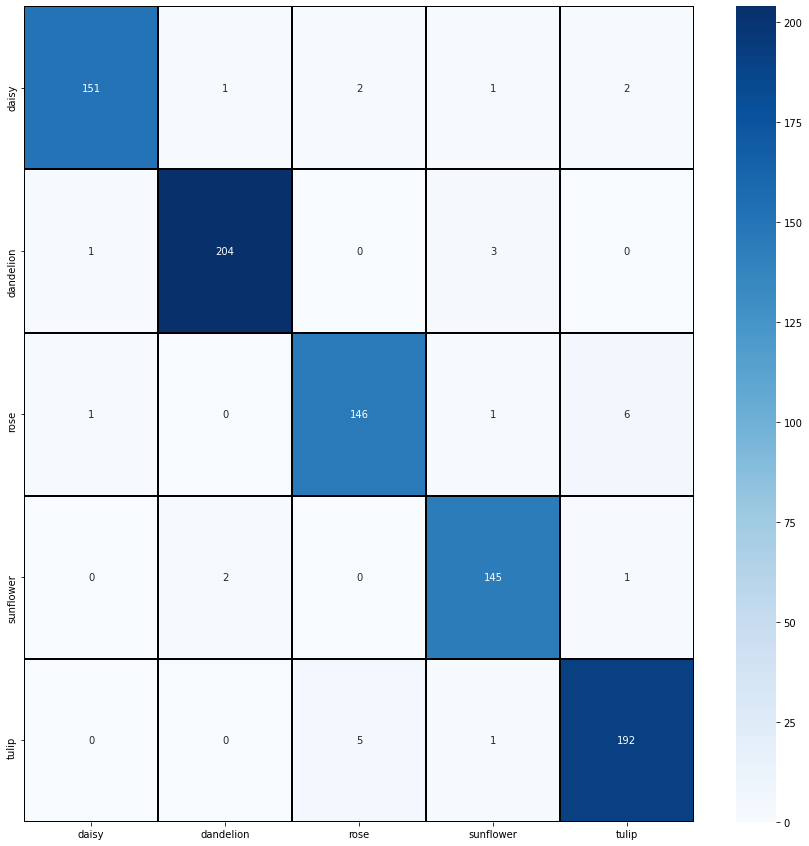

In [ ]:
#Heatmapa Confusion Matrix
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = categories , yticklabels = categories)

In [ ]:
# przygotowanie do wizualizacji predykcji
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

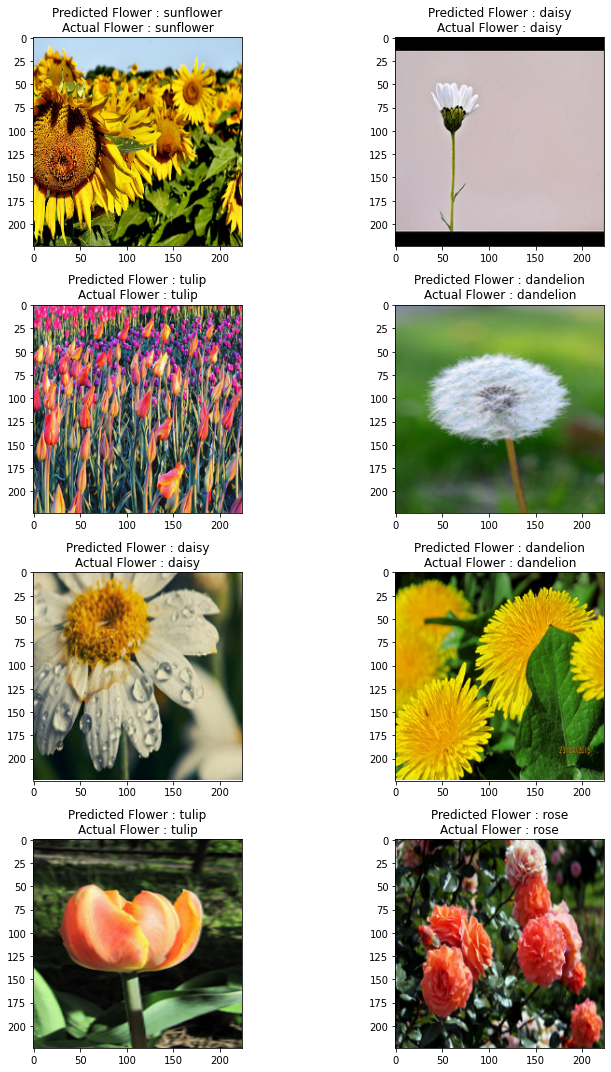

In [ ]:
#Prawidłowe predykcje
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ categories[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ categories[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1

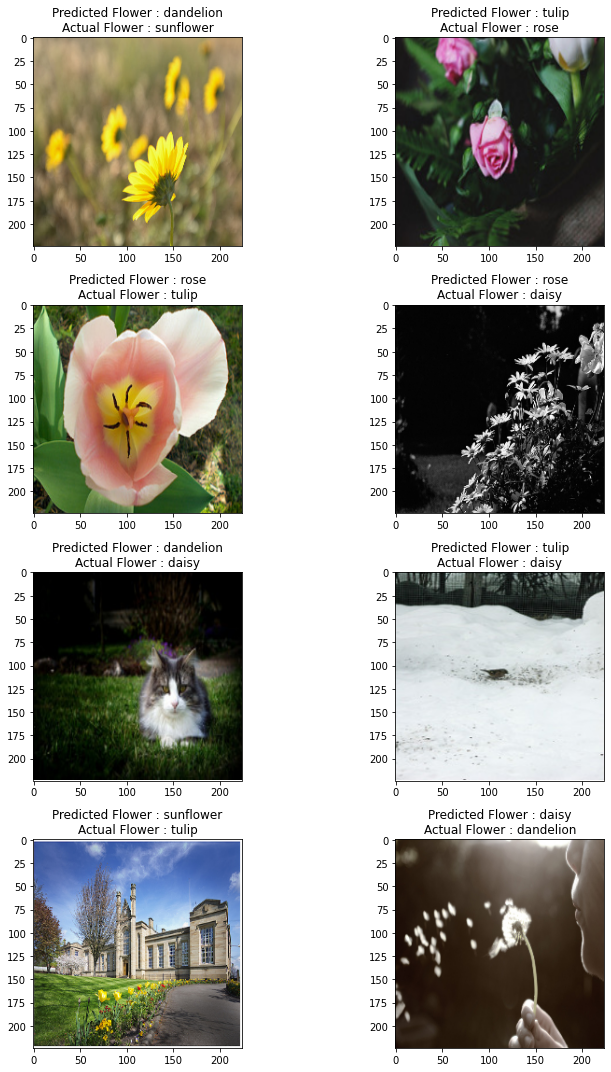

In [ ]:
# Błędne predykcje
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+categories[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+categories[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1